In [9]:

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import umap

import anndata
import scanpy as sc
#from egd_model import MULTIVI
import scvi
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph

In [2]:
#adata = anndata.read_h5ad("../Data/dogma_all_genes_cells_75unpaired_processed.h5ad.gz")
adata = anndata.read_h5ad("../Data/dogma_all_genes_cells_75unpaired_processed_mofa.h5ad.gz")
adata

AnnData object with n_obs × n_vars = 12121 × 114801
    obs: 'idx_rna', 'idx_atac', 'sample_type', 'batch', 'stim', 'protein_MS1', 'rna_MS1', 'peaks.MS', 'predicted.celltype.l1', 'idx_adt', 'majority_voting', 'modality'
    var: 'GeneID', 'Gene Symbol', 'Type', 'chr', 'start', 'end', 'len', 'star', 'idx', 'n_cells', 'modality'
    obsm: 'X_mofa', 'protein_expression'

In [3]:
scvi.model.MULTIVI.setup_anndata(adata, protein_expression_obsm_key='protein_expression')
adata.obs.majority_voting = (
    adata.obs.majority_voting
    # B cells
    .replace('Naive B cells', 'B Cell')
    .replace('Memory B cells', 'B Cell')
    .replace('Age-associated B cells', 'B Cell')
    .replace('Plasma cells', 'Plasma cells')  # 可合并也可保留

    # CD4+ T cells
    .replace('Tcm/Naive helper T cells', 'Naive CD4')
    .replace('Tem/Effector helper T cells', 'Effector CD4')
    .replace('Regulatory T cells', 'Regulatory CD4')

    # CD8+ T cells
    .replace('Tcm/Naive cytotoxic T cells', 'Naive CD8')
    .replace('Tem/Temra cytotoxic T cells', 'Effector CD8')
    .replace('Tem/Trm cytotoxic T cells', 'Effector CD8')
    .replace('CD8a/a', 'Effector CD8')

    # NK cells
    .replace('CD16+ NK cells', 'NK cells')
    .replace('CD16- NK cells', 'NK cells')

    # Monocyte-Macrophage
    .replace('Classical monocytes', 'Monocyte/Macrophage')
    .replace('Intermediate macrophages', 'Monocyte/Macrophage')

    # Dendritic cells
    .replace('Migratory DCs', 'DCs')
    .replace('pDC', 'DCs')

    # Other
    .replace('MAIT cells', 'MAIT cells')
    .replace('ILC3', 'ILC3')
)


INFO     Using column names from columns of adata.obsm['protein_expression']                                       


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.obsm['protein_expression'] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
/tmp/ipykernel_931023/2864763162.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Naive B cells', 'B Cell')
/tmp/ipykernel_931023/2864763162.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace('Memory B cells', 'B Cell')
/tmp/ipykernel_931023/2864763162.py:7: FutureWarning: The behavior of Se

In [4]:
sc.pp.neighbors(adata, use_rep="X_mofa", key_added="mofa")
#sc.tl.leiden(adata, neighbors_key="multiVI", key_added="multiVI_clusters", resolution=0.1)
sc.tl.umap(adata, min_dist=0.2, neighbors_key="mofa")

In [6]:
import sklearn.cluster
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. 提取 MultiVI 低维嵌入
latent = adata.obsm["X_mofa"]

from sklearn.decomposition import PCA
latent = PCA(n_components=10).fit_transform(latent)

# 2. 设定聚类数（根据 ground truth 细胞类型数）
n_clusters = adata.obs["majority_voting"].nunique()

# 3. 运行 K-means 聚类
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=12)
adata.obs["mofa_clusters"] = kmeans.fit_predict(latent)

# 4. 计算 ARI 和 NMI
true_labels = adata.obs["majority_voting"] # 真实细胞类型
pred_labels = adata.obs["mofa_clusters"]  # K-means 聚类标签

# 只保留不含 NaN 的行
valid_mask = ~true_labels.isna() & ~pred_labels.isna()
true_labels = true_labels[valid_mask].values
pred_labels = pred_labels[valid_mask].values

ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
asw = silhouette_score(latent[valid_mask], pred_labels)
print(f"Average Silhouette Width (ASW): {asw:.4f}")

Adjusted Rand Index (ARI): 0.1005
Normalized Mutual Information (NMI): 0.1856
Average Silhouette Width (ASW): 0.1705


In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import networkx as nx
from anndata import AnnData

def compute_graph_connectivity(adata: AnnData, embedding_key: str, label_key: str, k: int = 15) -> float:
    # Step 1: 获取嵌入和标签
    embedding = adata.obsm[embedding_key]
    labels = adata.obs[label_key]

    # Step 2: 创建邻接图（基于 kNN）
    knn = NearestNeighbors(n_neighbors=k+1).fit(embedding)
    distances, indices = knn.kneighbors(embedding)

    # 创建无向图（排除自身）
    G = nx.Graph()
    for i in range(len(embedding)):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    # Step 3: 对每个细胞类型计算最大连通子图比例
    unique_labels = labels.unique()
    scores = []

    for label in unique_labels:
        idx = np.where(labels == label)[0]
        subgraph = G.subgraph(idx)
        if len(subgraph) == 0:
            scores.append(0.0)
            continue
        largest_cc = max(nx.connected_components(subgraph), key=len)
        scores.append(len(largest_cc) / len(idx))

    # Step 4: 平均所有细胞类型的连通性得分
    return np.mean(scores)

score = compute_graph_connectivity(
    adata=adata,
    embedding_key="X_mofa",
    label_key="majority_voting",  # 真实细胞类型
    k=50
)
print("Graph Connectivity Score:", round(score, 4))


Graph Connectivity Score: 0.8546


In [5]:
adata.obsm["umap_Mofa"] = umap.UMAP(random_state=420).fit_transform(adata.obsm["X_mofa"])

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


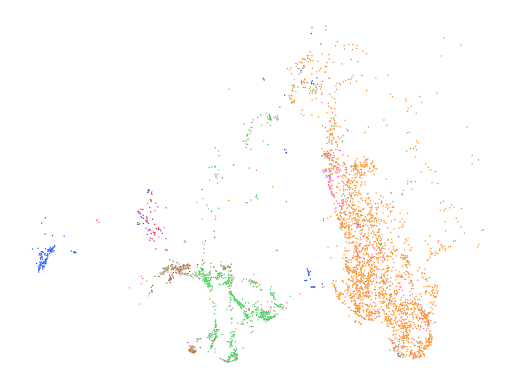

In [6]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_Mofa"][:,0],
    y=adata_plt.obsm["umap_Mofa"][:,1],
    hue=adata_plt.obs['predicted.celltype.l1'],
    s=1,
    palette='bright',
)
plt.legend().remove()
# 去除坐标轴和边框
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
sns.despine(left=True, bottom=True)  # 移除边框
plt.box(False)  # 进一步防止边框显示

# 展示图
plt.show()

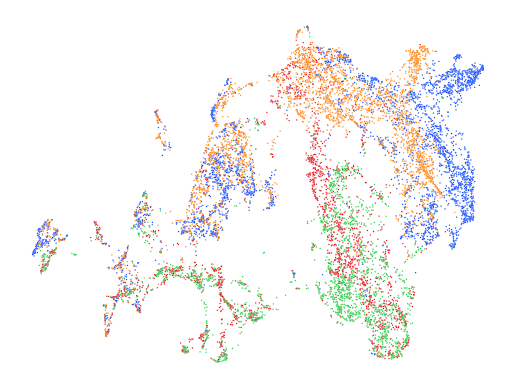

In [7]:
'''adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()'''
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_Mofa"][:,0],
    y=adata_plt.obsm["umap_Mofa"][:,1],
    hue=adata_plt.obs.sample_type,
    s=1,
    palette='bright',
)
plt.legend().remove()
# 去除坐标轴和边框
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
sns.despine(left=True, bottom=True)  # 移除边框
plt.box(False)  # 进一步防止边框显示
# 展示图
plt.show()

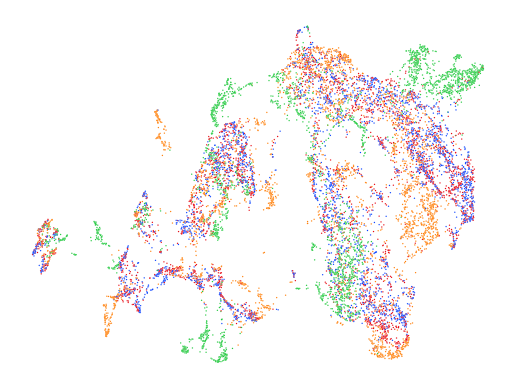

In [8]:
adata_plt = adata[np.random.choice(
        np.arange(adata.shape[0]), 
        adata.shape[0], 
        replace=False
    )].copy()
#adata_plt = adata_plt[~adata_plt.obs.final_ct.isin(["Unknown", "PBMC", "Bone_Marrow"])].copy()
sns.scatterplot(
    x=adata_plt.obsm["umap_Mofa"][:,0],
    y=adata_plt.obsm["umap_Mofa"][:,1],
    hue=adata_plt.obs.modality,
    s=1,
    palette='bright',
)
plt.legend().remove()
# 去除坐标轴和边框
plt.xticks([])
plt.yticks([])
plt.xlabel("")
plt.ylabel("")
sns.despine(left=True, bottom=True)  # 移除边框
plt.box(False)  # 进一步防止边框显示
# 展示图
plt.show()

In [13]:
def compute_batch_mixing(latent, batch_id, k):
    nng = kneighbors_graph(latent, n_neighbors=k).tocoo()
    batch_id = pd.Categorical(batch_id).codes
    self_id = batch_id[nng.row]
    ne_id = batch_id[nng.col]
    
    _, c = np.unique(batch_id, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

def compute_foscttm(latent_acc, latent_exp):
    """
    计算 FOSCTTM 分数
    
    返回: 平均 FOSCTTM 值
    """
    distances = cdist(latent_acc, latent_exp, metric='euclidean')  # 计算所有细胞的欧式距离
    foscttm_values = []
    num_cells=latent_exp.shape[0]

    for i in range(num_cells):  # 遍历所有已知匹配的细胞对
        d_true = distances[i, i]  # 真实匹配的距离
        d_others = distances[i, :]  # 该细胞到所有其他细胞的距离
        
        rank = np.sum(d_others < d_true) / num_cells  # 计算 FOSCTTM
        foscttm_values.append(rank)

    return np.mean(foscttm_values)  # 返回平均 FOSCTTM 值

In [14]:
latent = adata.obsm["X_mofa"]
enrichments = []
for K in [15,50,150,500]:
    print(K)
    enrichments.append(
            (K, 
            compute_batch_mixing(latent, adata.obs.modality, K))
        )
asw_modality = silhouette_score(latent, adata.obs["modality"], metric='euclidean')
print(f"ASW for modality: {asw_modality:.4f}")
print(enrichments)

15
50
150
500
ASW for modality: -0.0295
[(15, 2.578146913248815), (50, 2.2290566230322093), (150, 1.875316663761961), (500, 1.511356450380284)]


In [15]:
latent = adata.obsm["X_mofa"]
enrichments = []
for K in [15,50,150,500]:
    print(K)
    enrichments.append(
            (K, 
            compute_batch_mixing(latent, adata.obs.sample_type, K))
        )
asw_batch = silhouette_score(latent, adata.obs["sample_type"], metric='euclidean')
print(f"ASW for batch: {asw_batch:.4f}")
print(enrichments)

15
50
150
500
ASW for batch: 0.0117
[(15, 2.8969375778369133), (50, 2.6408571030400356), (150, 2.353001308803046), (500, 1.985234686893757)]
